<a href="https://colab.research.google.com/github/aju22/Variational-Auto-Encoders/blob/main/Variational_AutoEncoders_(VAEs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K

In [ ]:
K.clear_session()

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
IMG_SIZE = (64,64,3)
LATENT_DIM = 512
encoder_input = layers.Input(shape = IMG_SIZE)

# Model Architecture

In [ ]:
class ConvBlock(layers.Layer):
  def __init__(self, features, activation='relu'):
    super().__init__()
    
    self.conv = layers.Conv2D(features, 5, strides=2, padding='same')
    self.act = layers.LeakyReLU(0.02) 
    self.bn = layers.BatchNormalization()

  def call(self, x):

    return self.bn(self.act(self.conv(x)))  

In [ ]:
class DeConvBlock(layers.Layer):
  def __init__(self, features, activation=None):
    super().__init__()
    
    self.conv = layers.Conv2DTranspose(features, 5, strides=2, padding='same')
    self.act = layers.LeakyReLU(0.02)
    self.bn = layers.BatchNormalization()

  def call(self, x):

    return self.bn(self.act(self.conv(x)))  

## Encoder

In [ ]:
with tf.device(device_name):

  features = [32, 64, 128, 256, 512]
  convblocks = keras.Sequential(
        [ConvBlock(features[i]) for i in range(len(features))]
    )

  x = convblocks(encoder_input)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='selu')(x)
  encoder_output = layers.BatchNormalization()(x)

  mu = layers.Dense(LATENT_DIM)(encoder_output)
  log_var = layers.Dense(LATENT_DIM)(encoder_output)

  epsilon = K.random_normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
  sigma = tf.exp(0.5*log_var)

  z_eps = layers.Multiply()([sigma, epsilon])
  z = layers.Add()([mu, z_eps])

  encoder = keras.Model(encoder_input, outputs=[mu, log_var, z], name='encoder')

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 2, 2, 512)    4359360     ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['sequential[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['flatten[0][0]']                
                                                                                            

## Decoder

In [ ]:
with tf.device(device_name):

  decoder = keras.Sequential()

  decoder.add(layers.Dense(1024, activation='selu', input_shape=(LATENT_DIM, )))
  decoder.add(layers.Dense(8192, activation='selu'))
  decoder.add(layers.Reshape((4,4,512)))

  features = [256, 128, 64, 32]

  for feature in features:
    decoder.add(DeConvBlock(feature))

  decoder.add(layers.Conv2DTranspose(3, 5, activation = "sigmoid", strides = 1, padding = 'same'))
  decoder.add(layers.BatchNormalization()) 

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 de_conv_block (DeConvBlock)  (None, 8, 8, 256)        3278080   
                                                                 
 de_conv_block_1 (DeConvBloc  (None, 16, 16, 128)      819840    
 k)                                                              
                                                                 
 de_conv_block_2 (DeConvBloc  (None, 32, 32, 64)       205120    
 k)                                                   

In [ ]:
def mse_loss(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)

In [ ]:
def kl_loss(mu, log_var):
  loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
  return loss

In [ ]:
def vae_loss(y_true, y_pred, mu, log_var):

  return mse_loss(y_true, y_pred) + (1/(64*64))*kl_loss(mu, log_var)

## VAE

In [ ]:
with tf.device(device_name):
  mu, log_var, z = encoder(encoder_input)
  reconstructed = decoder(z)
  vae = keras.Model(encoder_input, reconstructed, name='vae')
  loss = kl_loss(mu, log_var)
  vae.add_loss(loss)

In [ ]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 512),        7511232     ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 3)    13278927    ['encoder[0][2]']                
                                                                                                

In [ ]:
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [ ]:
def train(training_dataset, num_epoch):

  optim = keras.optimizers.Adam(3e-4)
  mse_losses = []
  kl_losses = []
  random_vector = tf.random.normal(shape = (25, LATENT_DIM,))

  for epoch in range(1, num_epoch+1):
    print(f"------Epoch: {epoch}---------\n")
    
    for step, training_batch in enumerate(training_dataset):

      with tf.GradientTape() as tape:

        reconstructed = vae(training_batch)
        y_true = tf.reshape(training_batch, [-1])
        y_pred = tf.reshape(reconstructed, [-1]) 

        mse = mse_loss(y_true, y_pred)
        mse_losses.append(mse.numpy())
        
        kl = sum(vae.losses)
        kl_losses.append(kl.numpy())

        train_loss = 0.01*kl + mse

        grads = tape.gradient(train_loss, vae.trainable_variables)
        optim.apply_gradients(zip(grads, vae.trainable_variables))

      if step % 100 == 0:
        print(f"Epoch: {epoch} - Step: {step} - MSE: {mse.numpy()} - KL: {kl.numpy()}") 
        save_images(decoder, epoch, step, random_vector)

# Sample Working

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
# !gdown 1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP
# !unzip "anime faces.zip"

In [ ]:
image_dir = "cropped/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]

In [ ]:
image_size = 64
batch_size = 128

In [ ]:
def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

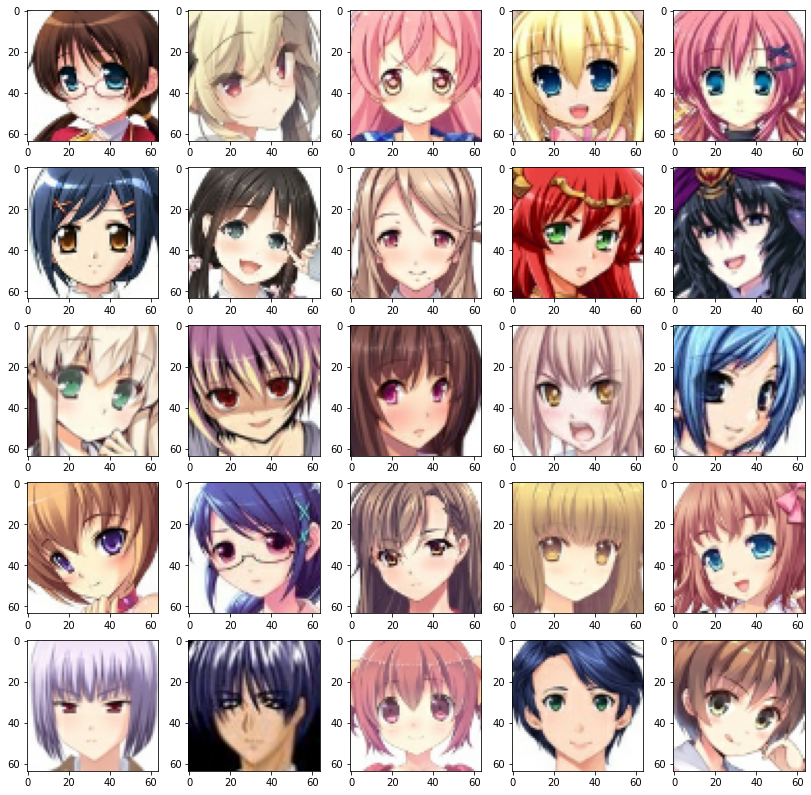

In [ ]:
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [ ]:
with tf.device(device_name):
  train(training_dataset, num_epoch=30)

------Epoch: 1---------

Epoch: 1 - Step: 0 - MSE: 0.042398035526275635 - KL: 2.8447110652923584
Epoch: 1 - Step: 100 - MSE: 0.046127136796712875 - KL: 0.11071854829788208
Epoch: 1 - Step: 200 - MSE: 0.04302368685603142 - KL: 0.11999177187681198
Epoch: 1 - Step: 300 - MSE: 0.04065385460853577 - KL: 0.10092335939407349
Epoch: 1 - Step: 400 - MSE: 0.03890189155936241 - KL: 0.12776492536067963
------Epoch: 2---------

Epoch: 2 - Step: 0 - MSE: 0.036916863173246384 - KL: 0.1084621474146843
Epoch: 2 - Step: 100 - MSE: 0.035849567502737045 - KL: 0.12784118950366974
Epoch: 2 - Step: 200 - MSE: 0.035490550100803375 - KL: 0.1338137835264206
Epoch: 2 - Step: 300 - MSE: 0.0334298200905323 - KL: 0.1519140899181366
Epoch: 2 - Step: 400 - MSE: 0.03200839087367058 - KL: 0.1678755134344101
------Epoch: 3---------

Epoch: 3 - Step: 0 - MSE: 0.03297118470072746 - KL: 0.15191929042339325
Epoch: 3 - Step: 100 - MSE: 0.03111826442182064 - KL: 0.1596120446920395
Epoch: 3 - Step: 200 - MSE: 0.030366109684109

In [ ]:
import cv2
output_dir = "output/"
images = sorted(os.listdir(output_dir))

fourcc = cv2.VideoWriter_fourcc(*'DIVX') 

frame = cv2.imread(os.path.join(output_dir, images[0]))

height, width, layers = frame.shape

video = cv2.VideoWriter("VAE_Generation.avi", fourcc, 20, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(output_dir,image)))
    
cv2.destroyAllWindows()
video.release()  